In [1]:
import os
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
import warnings
warnings.filterwarnings("ignore")
import tarfile

from terratorch.registry import BACKBONE_REGISTRY, TERRATORCH_BACKBONE_REGISTRY, TERRATORCH_DECODER_REGISTRY

/Users/samuel.omole/Desktop/repos/geofm/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [ ]:
# dataset_root = "/Users/samuel.omole/Desktop/repos/geofm_datasets"
# url = "https://drive.google.com/uc?id=1SycflNslu47yfMg2i_z8FqYkhZQv7JQM"
# archive = dataset_root + "/multi-temporal-crop-classification-subset.tar.gz"
# extract_dir = dataset_root + "/multi-temporal-crop-classification-subset"

# # download if missing
# if not os.path.isfile(archive):
#     gdown.download(url, output=archive, quiet=False)

# # extract if not already extracted
# if not os.path.isdir(extract_dir):
#     with tarfile.open(archive, "r:gz") as tar:
#         tar.extractall(path=dataset_root)

In [2]:
dataset_path = Path("/Users/samuel.omole/Desktop/repos/geofm_datasets/multi-temporal-crop-classification-subset")

# Adjusted dataset class for this dataset (general dataset could be used as well)
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=8,
    num_workers=2,
    data_root=dataset_path,
    train_transform=[
        terratorch.datasets.transforms.FlattenTemporalIntoChannels(),  # Required for temporal data
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
        terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
    expand_temporal_dimension=True,
    use_metadata=False, # The crop dataset has metadata for location and time #TODO: make True
    reduce_zero_label=True, 
)

# Setup train and val datasets
datamodule.setup("fit")

In [3]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

([494.905781, 815.239594, 924.335066, 2968.881459, 2634.621962, 1739.579917],
 [284.925432, 357.84876, 575.566823, 896.601013, 951.900334, 921.407808])

In [4]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

462

In [5]:
# checking datasets available bands
train_dataset.all_band_names

('BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2')

In [6]:
# checking datasets classes
train_dataset.class_names

('Natural Vegetation',
 'Forest',
 'Corn',
 'Soybeans',
 'Wetlands',
 'Developed / Barren',
 'Open Water',
 'Winter Wheat',
 'Alfalfa',
 'Fallow / Idle Cropland',
 'Cotton',
 'Sorghum',
 'Other')

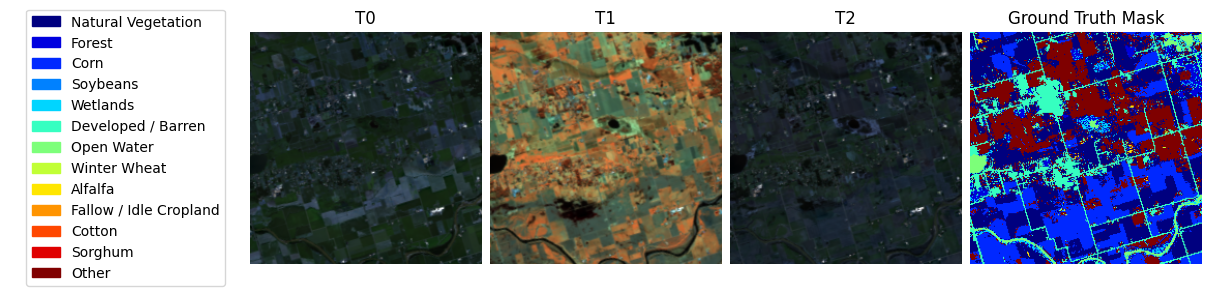

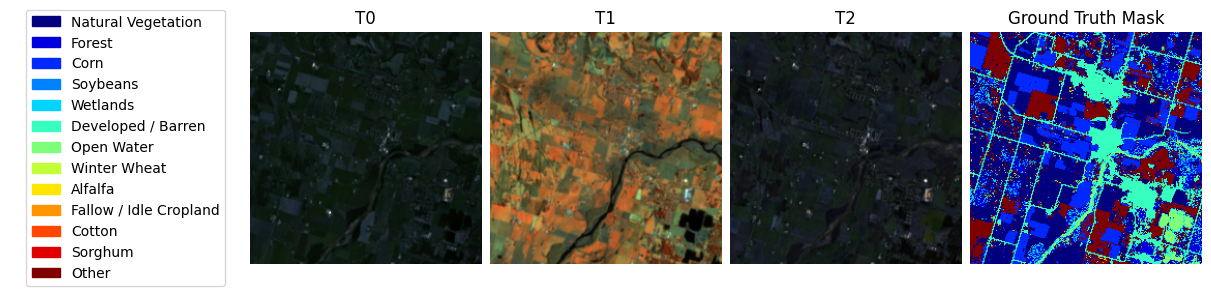

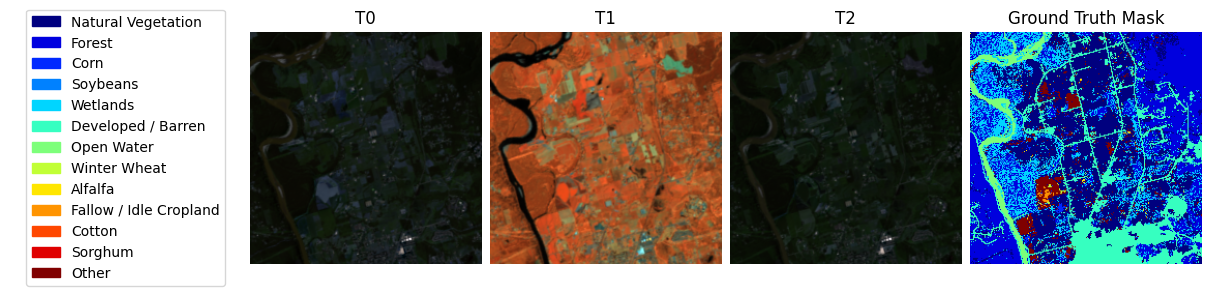

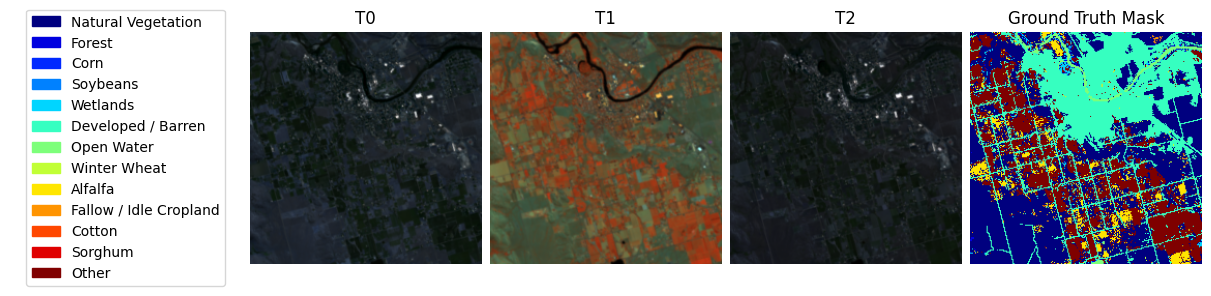

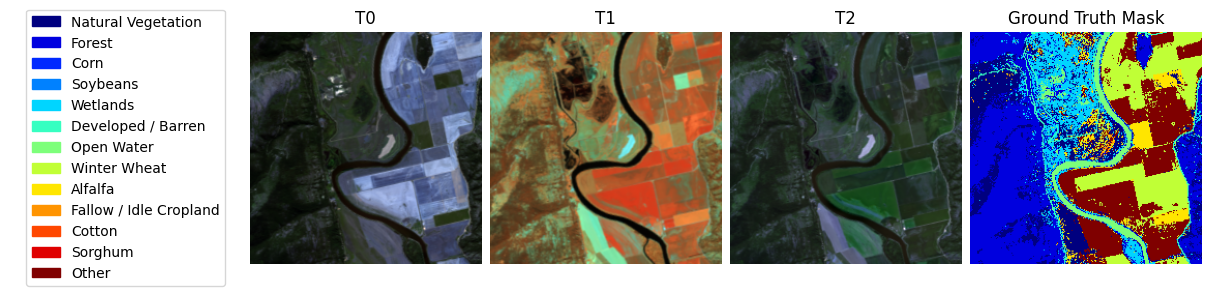

In [7]:
# plotting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [8]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

250

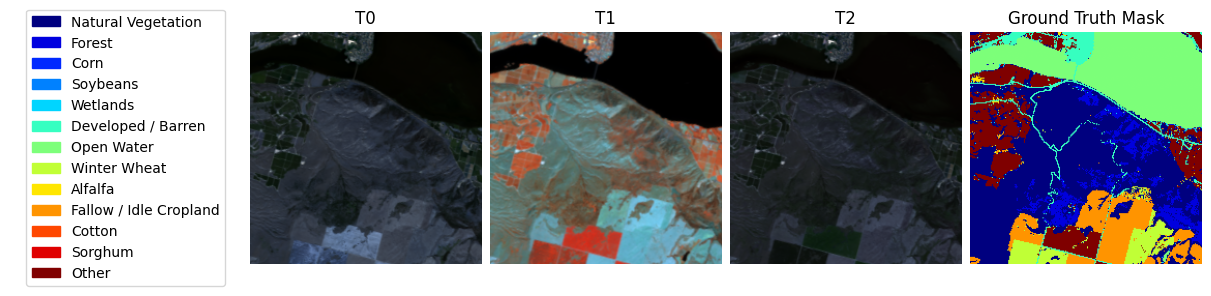

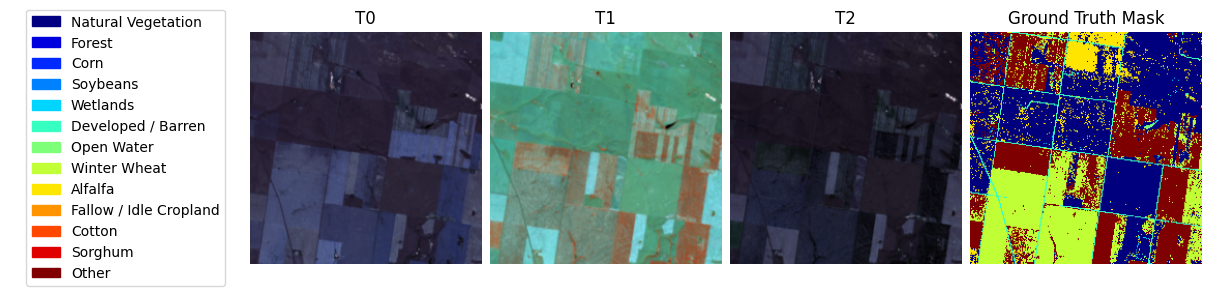

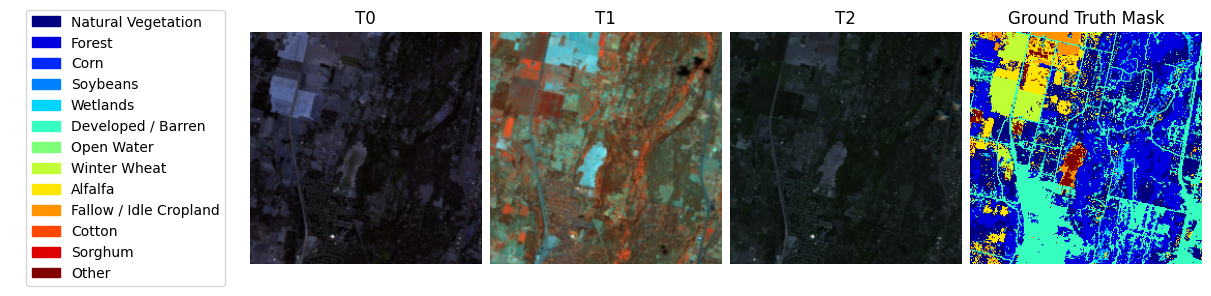

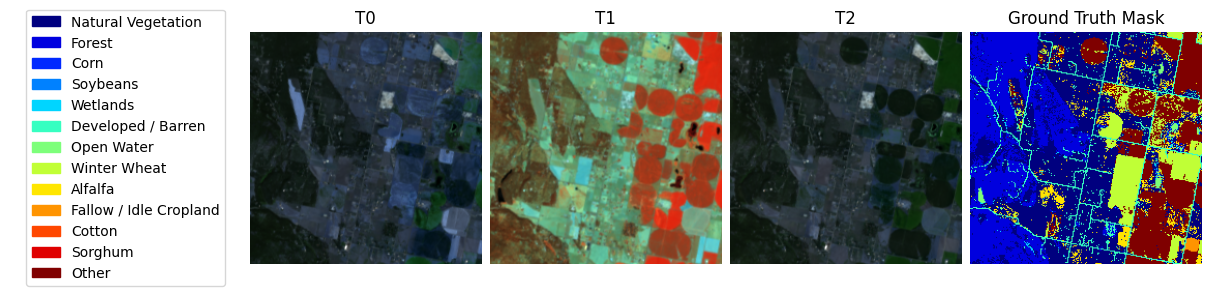

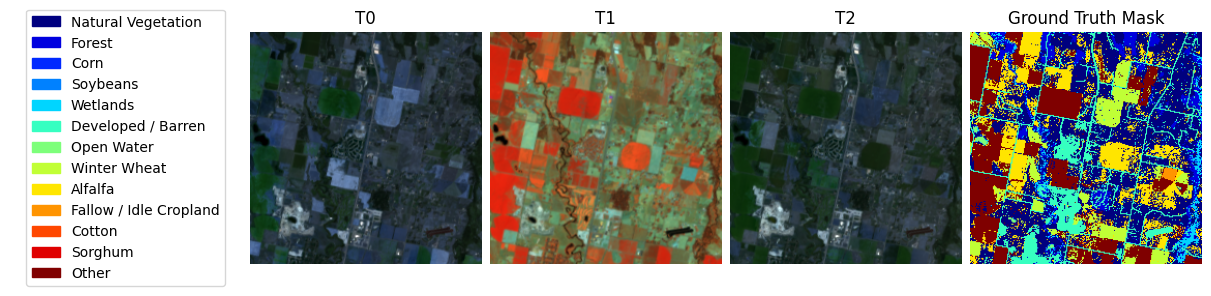

In [10]:
# plotting a few samples
for i in range(5):
    val_dataset.plot(val_dataset[i])

In [9]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

250

In [12]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="../output_multicrop/terramind_small_multicrop/checkpoints/",
    mode="min",
    monitor="val/loss",
    filename="best-loss",
    save_weights_only=True,
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="cpu",
    strategy="auto",
    devices=1, # Lightning multi-gpu often fails in notebooks
    precision=32,  # Speed up training
    num_nodes=1,
    logger=True, # Uses TensorBoard by default
    max_epochs=3, # For demos
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="../output_multicrop/terramind_small_multicrop",
)

# Model
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # TerraMind backbone
        "backbone": "terramind_v1_small",
        "backbone_pretrained": True,
        "backbone_modalities": ["S2L2A"],
        "backbone_bands": {"S2L2A": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"]},

        # Apply temporal wrapper (params are passed with prefix backbone_temporal)
        "backbone_use_temporal": True,
        "backbone_temporal_pooling": "concat",  # Defaults to "mean" which also supports flexible input lengths
        "backbone_temporal_n_timestamps": 3,  # Required for pooling = concat
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                "indices": [2, 5, 8, 11] # indices for terramind_v1_tiny, small, and base
                # "indices": [5, 11, 17, 23] # indices for terramind_v1_large
            },
            {
                "name": "ReshapeTokensToImage",
                "remove_cls_token": False,
            },
            {"name": "LearnedInterpolateToPyramidal"},            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 13,
    },
    
    loss="ce",
    lr=1e-4, # The optimal learning rate varies between datasets, we recommend testing different once between 1e-5 and 1e-4. You can perform hyperparameter optimization using terratorch-iterate.
    optimizer="AdamW",
    ignore_index=-1,
    freeze_backbone=True,  # Speeds up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    class_names=["Natural Vegetation", "Forest", "Corn", "Soybeans", "Wetlands", "Developed / Barren", "Open Water", "Winter Wheat", "Alfalfa", "Fallow / Idle Cropland", "Cotton", "Sorghum", "Other"],
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:root:Loaded weights for BLUE in position 0 of patch embed
INFO:root:Loaded weights for GREEN in position 1 of patch embed
INFO:root:Loaded weights for RED in position 2 of patch embed
INFO:root:Loaded weights for NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for SWIR_2 in position 5 of patch embed


In [13]:
# Training
trainer.fit(model, datamodule=datamodule)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │ 44.8 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 22.9 M                                                                                           
Non-trainable params: 21.9 M                                                                                       
Total params: 44.8 M                                                                                               
Total estimated model params size (MB): 179                                                                        
Modules in train mode: 286                                                                                         
Modules in eval mode: 0

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumen

In [14]:
best_ckpt_path = "../output_multicrop/terramind_small_multicrop/checkpoints/best-loss.ckpt"
trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

INFO: Restoring states from the checkpoint path at ../output_multicrop/terramind_small_multicrop/checkpoints/best-loss.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ../output_multicrop/terramind_small_multicrop/checkpoints/best-loss.ckpt
INFO: Loaded model weights from the checkpoint at ../output_multicrop/terramind_small_multicrop/checkpoints/best-loss.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ../output_multicrop/terramind_small_multicrop/checkpoints/best-loss.ckpt
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Test metric                 ┃                DataLoader 0                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│               test/Accuracy                │            0.22611048817634583             │
│        test/Class_Accuracy_Alfalfa         │           0.0008505556033924222            │
│          test/Class_Accuracy_Corn          │            0.14838099479675293             │
│         test/Class_Accuracy_Cotton         │           0.0009958563605323434            │
│   test/Class_Accuracy_Developed / Barren   │             0.1686483770608902             │
│ test/Class_Accuracy_Fallow / Idle Cropland │            0.021794214844703674            │
│         test/Class_Accuracy_Forest         │             0.5086488127708435             │
│   test/Class_Accuracy_Natural Vegetation   │             0.8394020795822144             │
│       test/Class_Accuracy_Open Water       │             0.566403329372406              │
│         test/Class_Accuracy_Other          │            0.04131152853369713             │
│        test/Class_Accuracy_Sorghum         │            0.010295252315700054            │
│        test/Class_Accuracy_Soybeans        │             0.2267988622188568             │
│        test/Class_Accuracy_Wetlands        │             0.2537386417388916             │
│      test/Class_Accuracy_Winter Wheat      │             0.1521679013967514             │
│               test/F1_Score                │            0.22162285447120667             │
│              test/IoU_Alfalfa              │           0.0008481197874061763            │
│               test/IoU_Corn                │            0.11721330136060715             │
│              test/IoU_Cotton               │           0.0009940817253664136            │
│        test/IoU_Developed / Barren         │            0.12771955132484436             │
│      test/IoU_Fallow / Idle Cropland       │            0.019297264516353607            │
│              test/IoU_Forest               │             0.2987784445285797             │
│        test/IoU_Natural Vegetation         │            0.28151553869247437             │
│            test/IoU_Open Water             │            0.45315006375312805             │
│               test/IoU_Other               │            0.03790466859936714             │
│              test/IoU_Sorghum              │            0.01000126264989376             │
│             test/IoU_Soybeans              │            0.14636309444904327             │
│             test/IoU_Wetlands              │            0.19170427322387695             │
│           test/IoU_Winter Wheat            │            0.11742056906223297             │
│            test/Pixel_Accuracy             │             0.3326488435268402             │
│                 test/loss                  │             2.085437059402466              │
│                 test/mIoU                  │             0.138685405254364              │
│              test/mIoU_Micro               │            0.19950737059116364             │
└────────────────────────────────────────────┴────────────────────────────────────────────┘

[{'test/loss': 2.085437059402466,
  'test/Accuracy': 0.22611048817634583,
  'test/Class_Accuracy_Natural Vegetation': 0.8394020795822144,
  'test/Class_Accuracy_Forest': 0.5086488127708435,
  'test/Class_Accuracy_Corn': 0.14838099479675293,
  'test/Class_Accuracy_Soybeans': 0.2267988622188568,
  'test/Class_Accuracy_Wetlands': 0.2537386417388916,
  'test/Class_Accuracy_Developed / Barren': 0.1686483770608902,
  'test/Class_Accuracy_Open Water': 0.566403329372406,
  'test/Class_Accuracy_Winter Wheat': 0.1521679013967514,
  'test/Class_Accuracy_Alfalfa': 0.0008505556033924222,
  'test/Class_Accuracy_Fallow / Idle Cropland': 0.021794214844703674,
  'test/Class_Accuracy_Cotton': 0.0009958563605323434,
  'test/Class_Accuracy_Sorghum': 0.010295252315700054,
  'test/Class_Accuracy_Other': 0.04131152853369713,
  'test/F1_Score': 0.22162285447120667,
  'test/IoU_Natural Vegetation': 0.28151553869247437,
  'test/IoU_Forest': 0.2987784445285797,
  'test/IoU_Corn': 0.11721330136060715,
  'test/IoU

INFO:root:Loaded weights for BLUE in position 0 of patch embed
INFO:root:Loaded weights for GREEN in position 1 of patch embed
INFO:root:Loaded weights for RED in position 2 of patch embed
INFO:root:Loaded weights for NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for SWIR_2 in position 5 of patch embed
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


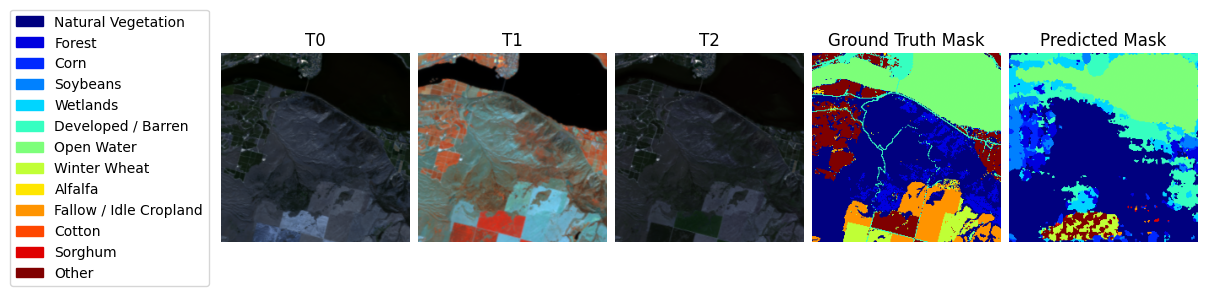

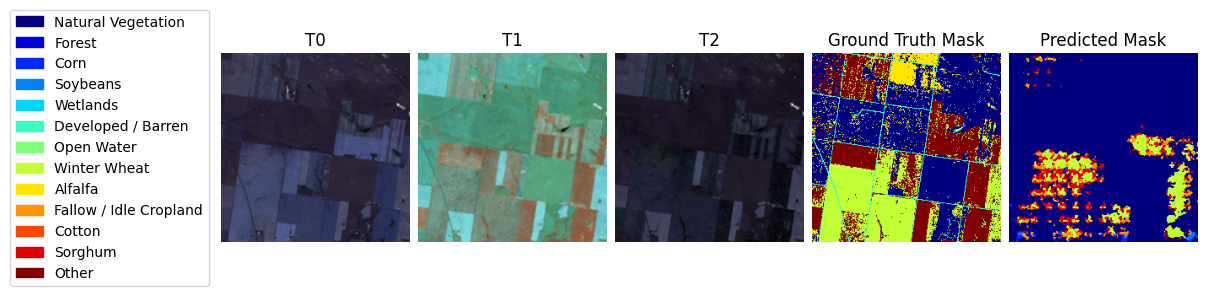

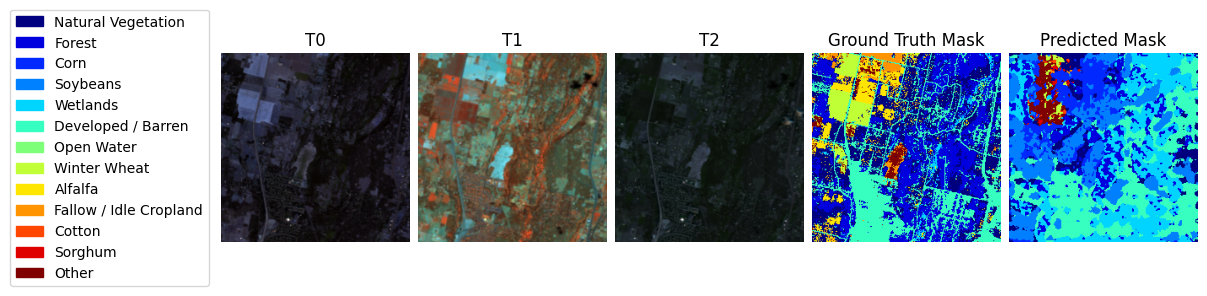

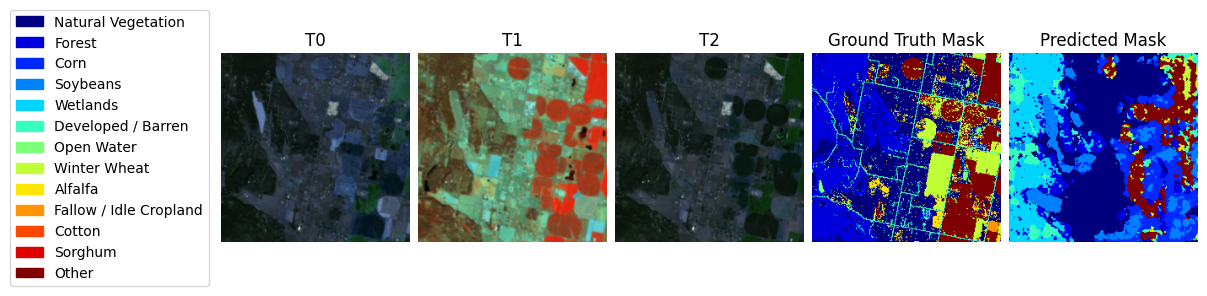

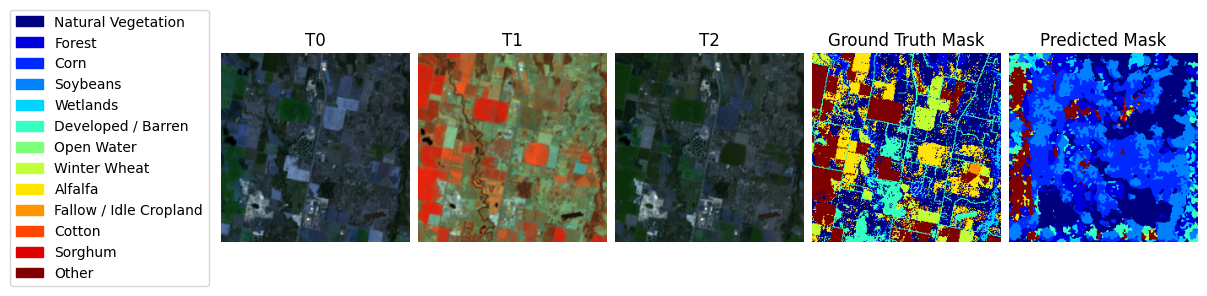

In [15]:
# Now we can use the model for predictions and plotting
model = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_factory=model.hparams.model_factory,
    model_args=model.hparams.model_args,
)

test_loader = datamodule.test_dataloader()
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"]
    images = images.to(model.device)
    masks = batch["mask"].numpy()

    with torch.no_grad():
        outputs = model(images)

    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5):
    sample = {
        "image": batch["image"][i].cpu(),
        "mask": batch["mask"][i],
        "prediction": preds[i],
    }
    test_dataset.plot(sample)
    plt.show()